### Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

100%|██████████| 195M/195M [03:00<00:00, 1.14MB/s] 

Extracting files...


Path to dataset files: C:\Users\LENOVO GAMING 3\.cache\kagglehub\datasets\grouplens\movielens-20m-dataset\versions\1


### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

### Loading Dataset

In [14]:
df = pd.read_csv("data/rating.csv")[:100_000]  
df = df[['userId', 'movieId', 'rating']]

### Encode user and movie

In [20]:
user_ids = df['userId'].unique().tolist()
movie_ids = df['movieId'].unique().tolist()

user2user_encode = {x: i for i, x in enumerate(user_ids)}
movie2movie_encode = {x: i for i, x in enumerate(movie_ids)}

df['user'] = df['userId'].map(user2user_encode)
df['movie'] = df['movieId'].map(movie2movie_encode)

num_users = len(user2user_encode)
num_movies = len(movie2movie_encode)

### Train Test Split

In [21]:
X = df[['user', 'movie']].values
y = df['rating'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Create Model

In [22]:
EMBEDDING_SIZE = 32

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size):
        super().__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_size)
        self.movie_embedding = tf.keras.layers.Embedding(num_movies, embedding_size)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        x = tf.concat([user_vector, movie_vector], axis=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

### Training Model

In [25]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_val, y_val),
    epochs=10, 
    batch_size=512 
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7001 - mae: 0.6436 - val_loss: 0.7984 - val_mae: 0.6947
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6858 - mae: 0.6342 - val_loss: 0.7959 - val_mae: 0.6918
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6610 - mae: 0.6206 - val_loss: 0.7977 - val_mae: 0.6923
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6397 - mae: 0.6090 - val_loss: 0.7978 - val_mae: 0.6904
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6112 - mae: 0.5956 - val_loss: 0.8096 - val_mae: 0.6945
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5837 - mae: 0.5789 - val_loss: 0.8160 - val_mae: 0.6956
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5491 - mae: 0.5615 - val_loss: 0.8252 - val_mae: 0.6995
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5216 - mae: 0.5458 - val_loss: 0.8435 - val_mae: 0.7052
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

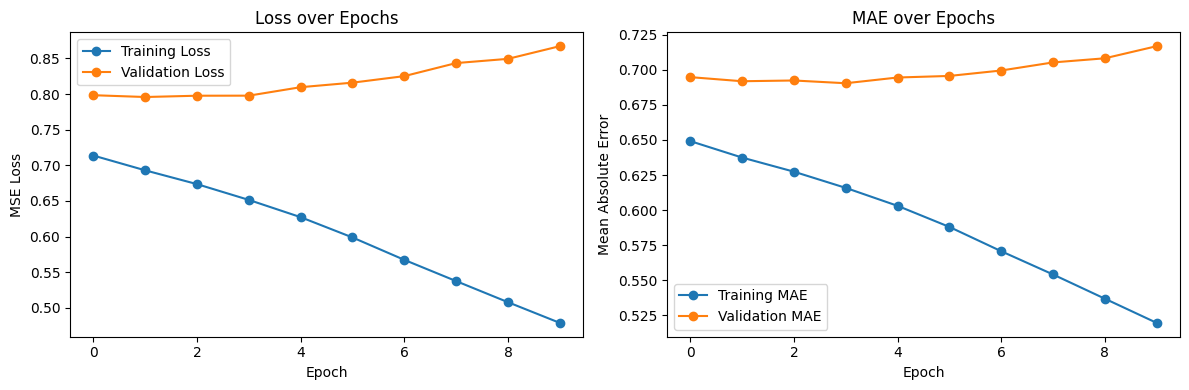

In [27]:
import matplotlib.pyplot as plt

# Visualisasi Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Visualisasi MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


### Testing Model

In [ ]:
def recommend_movies(user_id, top_n=10):
    encoded_user_id = user2user_encode[user_id]
    movie2movie_watched = df[df['userId'] == user_id]['movieId'].tolist()
    movie_not_watched = list(set(movie_ids) - set(movie2movie_watched))
    movie_not_watched_encoded = [movie2movie_encode[movie] for movie in movie_not_watched]
    
    user_array = np.array([encoded_user_id] * len(movie_not_watched_encoded))
    movie_array = np.array(movie_not_watched_encoded)
    predictions = model.predict(np.stack([user_array, movie_array], axis=1)).flatten()
    top_indices = np.argsort(predictions)[-top_n:][::-1]
    top_n_movies = [movie_ids[i] for i in top_indices]
    return top_n_movies

print("Recommended movies for user 1:", recommend_movies(user_id=1))

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
Recommended movies for user 1: [3352, 5313, 1147, 3667, 2652, 6570, 909, 7469, 5101, 1869]


### Checking Recomendation

In [29]:
movies_df = pd.read_csv("data/movie.csv")

In [30]:
recommended_ids = [3352, 5313, 1147, 3667, 2652, 6570, 909, 7469, 5101, 1869]
recommend_movies_df = movies_df[movies_df['movieId'].isin(recommended_ids)]
print(recommend_movies_df[['movieId', 'title']])

      movieId                                       title
892       909                       Apartment, The (1960)
1124     1147                   When We Were Kings (1996)
1785     1869                            Black Dog (1998)
2566     2652           Curse of Frankenstein, The (1957)
3265     3352                      Brown's Requiem (1998)
3576     3667                           Rent-A-Cop (1988)
5005     5101           Richard Pryor Here and Now (1983)
5216     5313                   Scorpion King, The (2002)
6460     6570  Lucía, Lucía (Hija del caníbal, La) (2003)


In [31]:
watched = df[df['userId'] == 1]['movieId'].tolist()
intersection = set(watched).intersection(set(recommended_ids))
if intersection:
    print("⚠️ Rekomendasi mengandung film yang sudah ditonton:", intersection)
else:
    print("✅ Semua rekomendasi adalah film baru untuk user ini.")

✅ Semua rekomendasi adalah film baru untuk user ini.


In [32]:
recommended_titles = movies_df[movies_df['movieId'].isin(recommended_ids)]

print("🎬 Top 10 Rekomendasi untuk User 1:\n")
for i, row in recommended_titles.iterrows():
    print(f"{row['movieId']}: {row['title']}")

🎬 Top 10 Rekomendasi untuk User 1:

909: Apartment, The (1960)
1147: When We Were Kings (1996)
1869: Black Dog (1998)
2652: Curse of Frankenstein, The (1957)
3352: Brown's Requiem (1998)
3667: Rent-A-Cop (1988)
5101: Richard Pryor Here and Now (1983)
5313: Scorpion King, The (2002)
6570: Lucía, Lucía (Hija del caníbal, La) (2003)


In [ ]:
filtered_df = 